# Doble pozo

In [1]:
import openmm as mm
from openmm import unit
from openmm import app
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

## Creamos el sistema

In [2]:
system = mm.System()

In [3]:
system.addParticle(39.948 * unit.amu) # masa del átomo de argón

0

In [4]:
system.getNumParticles()

1

# Añadimos el potencial externo

In [5]:
force = mm.CustomExternalForce('Eo*(C*x^4-x^2)+M*x + (K/2.0)*(y^2+z^2)')

In [6]:
force.addGlobalParameter('K',  100.0 * unit.kilocalories_per_mole/unit.angstrom**2) # No aplica en X
force.addGlobalParameter('Eo',  6.0* unit.kilocalories_per_mole/unit.angstrom**2) # Barrera
force.addGlobalParameter('C',  0.4* 1/unit.angstrom**2) # brazos abiertos o cerrados
force.addGlobalParameter('M', -0.25 * unit.kilocalories_per_mole/unit.angstrom) # Asimetricidad

3

In [7]:
force.addParticle(0)

0

In [8]:
system.addForce(force)

0

## Estado termodinámico

In [9]:
# Formalismo NVT
temperature = 300.0*unit.kelvin

## Parametros de la simulación

In [10]:
integration_timestep = 2.0*unit.femtoseconds
saving_timestep = 0.1*unit.picoseconds
simulation_time = 2.0*unit.nanoseconds

saving_steps = int(saving_timestep/integration_timestep)
num_saving_steps = int(simulation_time/saving_timestep)

## Integrador

In [11]:
friction   = 5.0/unit.picosecond
integrator = mm.LangevinIntegrator(temperature, friction, integration_timestep)

## Plataforma

In [12]:
platform = mm.Platform.getPlatformByName('CUDA')

## Reporteros

In [13]:
times = np.zeros(num_saving_steps, np.float32) * unit.picoseconds
positions  = np.zeros([num_saving_steps,3], np.float32) * unit.angstroms
velocities = np.zeros([num_saving_steps,3], np.float32) * unit.angstroms/unit.picosecond
potential_energies   = np.zeros([num_saving_steps], np.float32) * unit.kilocalories_per_mole
kinetic_energies     = np.zeros([num_saving_steps], np.float32) * unit.kilocalories_per_mole

## Condiciones iniciales

In [14]:
initial_positions  = [[-1.1, 0.0, 0.0]] * unit.angstroms

## Creamos el contexto

In [15]:
context = mm.Context(system, integrator, platform)

In [16]:
context.setPositions(initial_positions)

In [17]:
#context.setVelocitiesToTemperature(temperature)

## Llenamos los reporteros para el paso 0

In [18]:
state = context.getState(getEnergy=True, getPositions=True, getVelocities=True)

In [19]:
times[0] =  state.getTime()
positions[0] = state.getPositions()[0]
velocities[0] = state.getVelocities()[0]
kinetic_energies[0]=state.getKineticEnergy()
potential_energies[0]=state.getPotentialEnergy()

## Corriendo la simulación

In [20]:
for ii in tqdm(range(num_saving_steps)):
    context.getIntegrator().step(saving_steps)
    state_xx = context.getState(getEnergy=True, getPositions=True, getVelocities=True)
    times[ii] = state_xx.getTime()
    positions[ii] = state_xx.getPositions()[0]
    velocities[ii] = state_xx.getVelocities()[0]
    kinetic_energies[ii]=state_xx.getKineticEnergy()
    potential_energies[ii]=state_xx.getPotentialEnergy()
    #print('Paso',ii,'con tiempo', state_xx.getTime())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:19<00:00, 1035.13it/s]


## Representamos los datos de la simulación

### Trayectoria

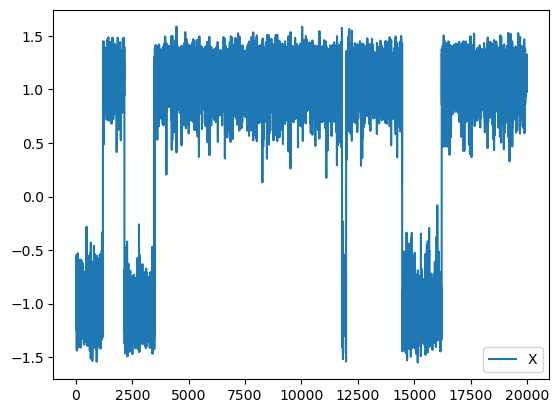

In [22]:
plt.plot(positions[:,0], label='X')
plt.legend()
plt.show()

- Vamos a jugar con la temperatura... qué pasará a T más alta... o qué pasará a T más baja.
- Vamos a intentar representar gráficamente la función del potencial en X para los valores usados de Eo, C y M.
- Vamos a variar los valores de Eo, C y M para ver qué pasa.